# Tagging pizza with ddlite: learning and labeling function iteration

## Introduction
We want an accurate tagger for pizza types in yelp reviews. 

Here's the pipeline we'll follow:

1. Get candidates from previous section
2. Create a test set
3. Write labeling functions
4. Learn the tagging model

In [297]:
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *
np.random.seed(seed=1701)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading candidate extractions
First, we'll load in the pickled candidates that we created in the last notebook. We can construct an `Entities` object with the file.

In [2]:
E = Entities('yelp_tag_saved_entities_v5.pkl')

## `DDLiteModel` objects and feature generation
We'll then create a `DDLiteModel` object for our extracted pizza candidates. This lets us iterate with our model and labeling functions. Since `Entities` object defines a feature generation method, features are automatically created when we initialize a `DDLiteModel` object. These are generic features from the NLP markup and dependency tree in the neighborhood of the mention.  

Here, we pickle our feature matrix so we don't have to recompute it in the future.

In [278]:
feats = None

pkl_f = 'yelp_tag_feats_v1.pkl'
try:
    with open(pkl_f, 'rb') as f:
        feats = cPickle.load(f)
except:
    %time E.extract_features()
    with open(pkl_f, 'w+') as f:
        cPickle.dump(E.feats, f)

DDL = DDLiteModel(E, feats)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 27944 features for each of 1021 mentions


We need a blind, gold standard ground truth set to evaluate our predictions. We label 198 candidates with truth values.

We add these by using the uids for the candidates we want, and align these with a value of 1 for positive or a value of -1 for negative. 

In [279]:
uids = []
for i in range(198):
    uids.append(E[i].uid)
    #print E[i].mention(attribute='words')

In [280]:
#uid example:
uids[0]

"reviews_kFVapB4z_5VoOnYazF_ERA.txt::19::[[4, 5, 6]]::['chickenm1']"

In [281]:
gt = np.array([1,1,1,-1,1,1,1,-1,1,-1,1,-1,-1,1,-1,-1,1,1,1,1,1,1,1,1,1,-1,-1,-1,1,
               1,1,1,1,1,1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,-1,-1,-1,-1,1,1,1,1,1,
               -1,1,-1,1,-1,-1,1,1,1,-1,1,1,-1,1,1,1,1,-1,1,1,1,-1,1,-1,-1,-1,-1,1,
               1,1,1,1,1,-1,1,1,1,-1,1,  1,1,-1,1,1,1,1,-1,1,1,1,1,1,1,-1,-1,1,1,1,
               -1,1,1,1,1,1,1,1,-1,1,-1,1,1,1,1,-1,1,-1,1,1,-1,-1,-1,-1,1,-1,-1,1,1,
               1,1,1,1,1,1,1,1,1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,-1,1,1,1,
               1,1,1,-1,1,1,-1,1,1,1,1,-1,1,1,1,1,-1,1,1,1])


Well load in a set now using `DDL.update_gt()` and set it as the holdout. 

We assign half of the holdout to a validation set for parameter tuning, and the other half to a test set.

In [282]:
DDL.update_gt(gt[:100], uids=uids[:100])
DDL.set_holdout(validation_frac=0.5)

## Building a ground truth set with MindTagger
In order to evaluate our labeling functions and learning results, we'll create a small set of ground truth labels for some candidates using [Mindtagger](http://deepdive.stanford.edu/labeling). This will highlight each candidate in the sentence in which it appears. We set the response to yes if it is a mention is a pizza type, and no otherwise. It is ok to abstain from labeling. 

In [283]:
DDL.open_mindtagger(num_sample=25, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


Now, we'll retrieve the tags and add them to our `DDLiteModel`. We also use additional gold labels to evaluate our labeling functions against the *development set*.

In [284]:
DDL.add_mindtagger_tags()

In [285]:
DDL.update_gt(gt[100:], uids=uids[100:])

## Writing labeling functions
One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions.

DDLite uses data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true pizza type mention. 

Since our training data is not manually labeled, we generate potentially noisy labels (high recall/low precision). 

Labeling functions, or LFs, are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example).

Here are our LFs:

In [296]:
#Negative LFs

def LF_like(m):
    return 1 if ('like' in m.post_window('lemmas')) or ('like' in m.pre_window('lemmas')) else 0

def LF_love(m):
    return 1 if ('love' in m.post_window('lemmas')) or ('love' in m.pre_window('lemmas')) else 0

def LF_usually(m):
    return 1 if ('usually' in m.post_window('lemmas')) or ('usually' in m.pre_window('lemmas')) else 0

def LF_favorite(m):
    return 1 if ('favorite' in m.post_window('lemmas')) or ('favorite' in m.pre_window('lemmas')) else 0

peprsausage = ["pepperoni", "sausage", "cheese"]
def LF_pepsau(m):
    for p in peprsausage:
        if (p in m.mention('words')):
            return 1
    return 0

order = ["ordered", "had", "tried", "ate", "have", "has", "eat", "order"]
def LF_order(m):
    for p in order:
        if (p in m.pre_window('lemmas')):
            return 1
    return 0

#Positive LFs

def LF_notLike(m):
    return -1 if ('don\'t like' in m.post_window('lemmas')) or ('don\'t like' in m.pre_window('lemmas')) else 0

def LF_bad(m):
    return -1 if ('bad' in m.post_window('lemmas')) or ('bad' in m.pre_window('lemmas')) else 0

POS = ["VB", "VBD", "VBN", "VBP", "VBZ", "PRP", "RB", "RBR", "RBS"] 
def LF_pos(m):
    for p in POS:
        if (p in m.mention('poses')):
            return -1
    return 0

def LF_prep(m):
    for prep in ["IN"]:
        if (prep in m.mention('poses')):
            return -1
    return 0

miscneg = ["or"] 
def LF_miscneg(m):
    for p in miscneg:
        if (p in m.mention('words')):
            return -1
    return 0

otherFood = ["burger", "salad", "sandwich", "wings", "beer"]
def LF_otherFood(m):
    for food in otherFood:
        if (food in m.mention(attribute='words')):
            return -1
    return 0



We collect them and apply them to mentions. If we define more LFs later, we can apply them incrementally or overwrite all the LFs so far.

In [287]:
LFs = [LF_like, LF_love, LF_usually, LF_favorite, LF_notLike, LF_bad, LF_prep, LF_otherFood, LF_pos, 
       LF_miscneg, LF_pepsau, LF_order]

DDL.apply_lfs(LFs, clear=True)

We'll use ddlite's LF assessment utilities to debug and analyze our LFs before running inference. First, we'll generate summary plots which show the following:

* Do the LFs cover the data well or do we have many candidates for which all of the LFs abstained?
* Is there overlap between the LFs? Do many return positive or negative labels for the same candidate?
* Do the LFs conflict with each other? Do candidates tend to have many of one type of label, or a mix?

In [288]:
DDL.print_lf_stats()

LF stats on training set
Coverage:	62.432%
Overlap:	20.847%
Conflict:	11.292%


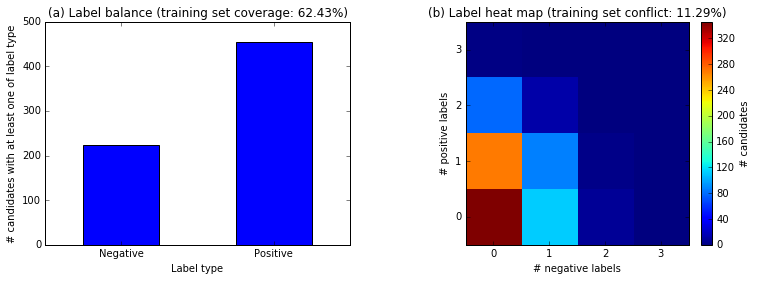

In [289]:
DDL.plot_lf_stats()

Below are tables of LFs with the most conflict, lowest coverage, and lowest empirical accuracy as compared to the development set labels.

In [290]:
DDL.top_conflict_lfs(n=3)

Labeling function,Percent candidates where LF has conflict
LF_prep,9.01%
LF_pepsau,8.58%
LF_order,2.39%


In [291]:
DDL.lowest_coverage_lfs(n=3)

Labeling function,Candidate coverage
LF_notLike,0.00%
LF_bad,0.11%
LF_usually,0.54%


In [292]:
#Show the n LFs with the lowest empirical accuracy against ground truth for candidates in the devset
DDL.lowest_empirical_accuracy_lfs(n=10) 

100% accuracy and 0 generalization score are "perfect"


Labeling function,Positive accuracy,Gen. score
LF_usually,0.00% (n=0),0.00 (n=0)
LF_love,66.67% (n=3),0.33 (n=2)
LF_like,66.67% (n=3),0.17 (n=2)
LF_pepsau,70.37% (n=27),0.04 (n=12)
LF_order,90.00% (n=20),0.10 (n=4)
LF_favorite,100.00% (n=1),1.00 (n=0)
Labeling function,Negative accuracy,Gen. score
LF_bad,0.00% (n=0),0.00 (n=0)
LF_pos,33.33% (n=3),0.33 (n=1)
LF_prep,88.89% (n=9),0.11 (n=8)


In [293]:
DDL.lf_summary_table()

Labelingfunction,Labeltype,Candidatecoverage,Candidateconflict,Positiveaccuracy,Positivegen. score,Negativeaccuracy,Negativegen. score
LF_otherFood,Negative,1.52%,0.54%,N/A,N/A,100.00% (n=1),1.00 (n=0)
LF_notLike,Negative,0.00%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
LF_bad,Negative,0.11%,0.00%,N/A,N/A,0.00% (n=0),0.00 (n=0)
LF_pos,Negative,5.32%,1.41%,N/A,N/A,33.33% (n=3),0.33 (n=1)
LF_prep,Negative,17.16%,9.01%,N/A,N/A,88.89% (n=9),0.11 (n=8)
LF_miscneg,Negative,1.41%,0.76%,N/A,N/A,100.00% (n=3),0.00 (n=1)
LF_order,Positive,19.44%,2.39%,90.00% (n=20),0.10 (n=4),N/A,N/A
LF_usually,Positive,0.54%,0.00%,0.00% (n=0),0.00 (n=0),N/A,N/A
LF_favorite,Positive,1.19%,0.00%,100.00% (n=1),1.00 (n=0),N/A,N/A
LF_love,Positive,3.15%,0.87%,66.67% (n=3),0.33 (n=2),N/A,N/A


We observe LFs have a wide range of accuracy (some very low)
The LFs have a wide generalization score range (some very low)

DDLite states that LFs with a sufficiently large sample size  could be an indication that the LF is buggy.

## Learning
To learn weights for the features and LFs, DDLite use a simple, regularized logistic regression model. 

We tell ddlite to log the results and print out a summary table

Begin training for mu = 1e-05
	Learning epoch = 0	Gradient mag. = 0.015742
	Learning epoch = 100	Gradient mag. = 0.017141
	Learning epoch = 200	Gradient mag. = 0.017356
	Learning epoch = 300	Gradient mag. = 0.017436
	Learning epoch = 400	Gradient mag. = 0.017465
Final gradient magnitude for mu=0.000: 0.017
Begin training for mu = 0.001
	Learning epoch = 0	Gradient mag. = 0.015742
	Learning epoch = 100	Gradient mag. = 0.016990
	Learning epoch = 200	Gradient mag. = 0.017149
	Learning epoch = 300	Gradient mag. = 0.017207
	Learning epoch = 400	Gradient mag. = 0.017229
Final gradient magnitude for mu=0.001: 0.017
Begin training for mu = 0.01
	Learning epoch = 0	Gradient mag. = 0.015742
	Learning epoch = 100	Gradient mag. = 0.016569
	Learning epoch = 200	Gradient mag. = 0.016569
	Learning epoch = 300	Gradient mag. = 0.016568
	Learning epoch = 400	Gradient mag. = 0.016568
Final gradient magnitude for mu=0.010: 0.017
Begin training for mu = 0.1
	Learning epoch = 0	Gradient mag. = 0.015742
	Lea

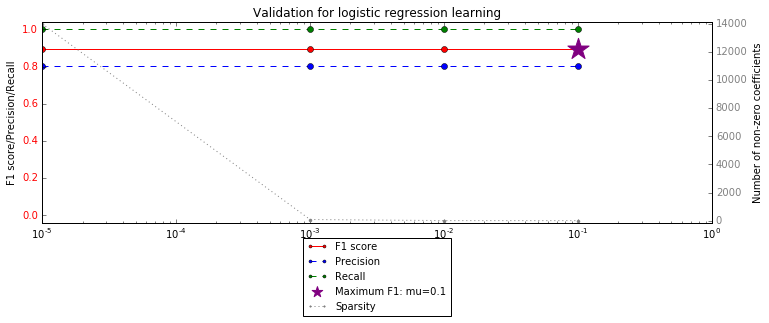

CPU times: user 24.4 s, sys: 540 ms, total: 24.9 s
Wall time: 6.5 s


<ddlite.ModelLog instance at 0x7fb87550cbd8>

In [300]:
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-5, 1e-3, 1e-2, 1e-1])
DDL.set_use_lfs(True)
%time DDL.learn_weights(sample=False, n_iter=500, alpha=0.5, mu=mu_seq,\
                        bias=True, verbose=True, log=True)

We can use [DeepDive-style calibration plots](http://deepdive.stanford.edu/calibration) to evaluate the quality of our predictions.

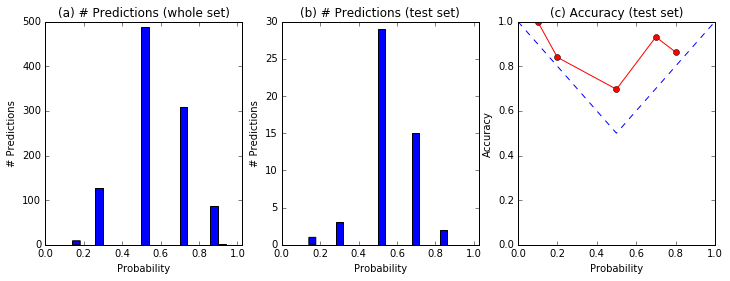

In [295]:
DDL.plot_calibration()

## Iterating with labeling functions
After analyzing our LFs and obtaining model results, we can revise our LF set. We can see all of the results thus far, and reopen MindTagger to see some mentions that aren't currently covered by LFs.

In [219]:
DDL.show_log()

ID,# LFs,Test set size,Use LFs,Model,Precision,Recall,F1
0,12,50,True,Joint,0.791,1.000,0.883


In [220]:
DDL.get_predicted_probability()

array([ 0.50120192,  0.50120192,  0.85977168, ...,  0.7127112 ,
        0.7127112 ,  0.50120192])

In [221]:
print len(DDL.get_predicted())
print DDL.get_predicted()
neg_count = 0
pos_count = 0
for c in DDL.get_predicted():
    if c == -1.:
        neg_count += 1
    else:
        pos_count += 1
print "neg count:", neg_count
print "pos_count:", pos_count

1021
[ 1.  1.  1. ...,  1.  1.  1.]
neg count: 136
pos_count: 885


In [231]:
import collections

names = []

print "POSITIVE CANDIDATES:\n"
for i in range(len(DDL.get_predicted())):
    if DDL.get_predicted()[i] == 1.:
        name = " ".join(DDL.C[i].mention('words'))
        print " ", name
        names.append(name)

print "\n\nNEGATIVE CANDIDATES:\n"
for i in range(len(DDL.get_predicted())):
    if DDL.get_predicted()[i] == -1.:
        name = " ".join(DDL.C[i].mention('words'))
        print " ", name

print "\n\nMost Common pizza types:\n"
collections.Counter(names).most_common(15)

POSITIVE CANDIDATES:

  Chicken Potato Pizza
  Chicken and a Hawaiian pizza
  sausage thin crust pizza
  Pepperoni Pizza Hot Wings Pizza
  Salami and Artichoke Pizza
  salami and artichoke pizza
  pepperoni and cheese pizza
  sausage on the pizza
  Italian meat pizzas
  Ham and Pineapple pizza
  chicken bacon pizza
  chicken drummies to pizza
  pepperoni and cheese only pizzas
  pepperoni and bell pepper pizza
  sausage and mushroom pizza
  Chicken and Dried Plum pizza
  chicken and spiced plum pizza
  spinach and feta pizza
  Chicken Parm Pizza
  pepperoni and Italian sausage Pizza
  Italian sausage Pizza
  Chicken salad and a pizza
  sausage on the pizza
  Spinach and Feta pizza
  Chicken and Dry Plum pizza
  spinach and feta pizza
  Chicken Ranchero Pizza
  Chicken and Dry Plum Pizza
  pepperoni deep dish pizza
  Chicken Topper pizza
  chicken and ground beef pizza
  chicken garlic pizza
  pepperoni or sausage pizza
  chicken bacon ranch pizza
  bacon ranch pizza
  pepperoni and the

[(u'pepperoni and sausage pizza', 29),
 (u'chicken pesto pizza', 25),
 (u'pepperoni and mushroom pizza', 18),
 (u'sausage on the pizza', 11),
 (u'sausage and pepperoni pizza', 11),
 (u'sausage on my pizza', 10),
 (u'Italian style pizza', 10),
 (u'bacon cheeseburger pizza', 9),
 (u'sausage and mushroom pizza', 8),
 (u'spinach and artichoke pizza', 6),
 (u'pepperoni and cheese pizza', 6),
 (u'Italian sausage pizza', 6),
 (u'pepperoni and bacon pizza', 5),
 (u'Chicken Alfredo pizza', 5),
 (u'chicken and bacon pizza', 5)]